# A Simple Hamiltonian Monte Carlo Example with TensorFlow Probability

In this notebook we want to revisit a simple bayesian inference example worked out in [this blog post](https://juanitorduz.github.io/intro_pymc3/). This time we want to use [TensorFlow Probability](https://www.tensorflow.org/probability) (TFP) instead of [PyMC3](https://docs.pymc.io/notebooks/getting_started.html). 

**References:**
- [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) is an amazing reference for Bayesian analysis. It also has a sequence of online lectures freely available on [YouTube](https://www.youtube.com/watch?v=4WVelCswXo4&list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI).

- [An introduction to probabilistic programming, now available in TensorFlow Probability](https://blog.tensorflow.org/2018/12/an-introduction-to-probabilistic.html)

- There are many examples on the [TensorFlow's GitHub repository](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/examples/jupyter_notebooks). I am following the case study [Bayesian Switchpoint Analysis](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Switchpoint_Analysis.ipynb) for this example. 

## Prepare Notebook

In [1]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions

# Data Viz. 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

# Get TensorFlow version.
print(f'TnesorFlow version: {tf.__version__}')
print(f'TnesorFlow Probability version: {tfp.__version__}')

TnesorFlow version: 2.2.0
TnesorFlow Probability version: 0.10.0


## Generate Data

We generate sample data from a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) using [TensorFlow Probability Distributions](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions) (see [here](https://juanitorduz.github.io/intro_tfd/) for an introduction to this module). Recall, 

$$
y \sim \text{Poisson}(\lambda) \quad \text{means} \quad P(y=k) = \frac{\lambda^k e^{-k}}{k!} \quad \text{for} \quad \lambda > 0, k\in \mathbb{N}_{\geq 0} 
$$

In [2]:
tf.random.set_seed(seed=42)
# Number of samples. 
n = 100
# True rate parameter. 
rate_true = 2.0
# Define Poisson distribution with the true rate parameter. 
poisson_true = tfd.Poisson(rate=rate_true)
# Generate samples.
poisson_samples = poisson_true.sample(sample_shape=n)
poisson_samples 

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([3., 3., 3., 1., 2., 1., 2., 0., 0., 2., 2., 1., 2., 2., 0., 3., 1.,
       4., 1., 1., 2., 0., 3., 4., 1., 3., 1., 2., 2., 0., 0., 2., 1., 1.,
       3., 5., 4., 3., 1., 4., 2., 2., 0., 2., 2., 4., 4., 2., 0., 4., 2.,
       4., 1., 1., 2., 1., 1., 1., 4., 1., 3., 3., 1., 3., 0., 1., 1., 3.,
       5., 1., 2., 2., 4., 0., 2., 3., 1., 3., 2., 4., 2., 2., 3., 2., 1.,
       3., 1., 1., 0., 1., 2., 1., 2., 3., 4., 3., 2., 1., 0., 1.],
      dtype=float32)>

Let us plot the sample distribution.

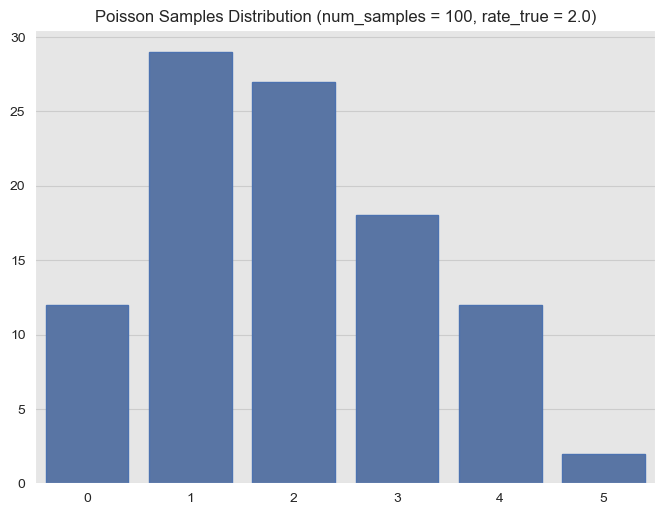

In [3]:
y_range, idy, c = tf.unique_with_counts(poisson_samples)

fig, ax = plt.subplots()
sns.barplot(x=y_range.numpy(), y=c.numpy(), color=sns_c[0], edgecolor=sns_c[0], ax=ax)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set(title=f'Poisson Samples Distribution (num_samples = {n}, rate_true = {rate_true})');


## Set Prior Distribution

We use a gamma distribution as prior. The reason for it is because we know the Poisson is [conjugate](https://en.wikipedia.org/wiki/Conjugate_prior) to the gamma distribution. Hence, it is possible to get an analytical solution. 

**Remark:** In most real applications an analytical solution is hopeless. 

$$
y \sim \text{Poisson}(\lambda) \quad \text{with} \quad \lambda \sim \Gamma(a, b)
$$

In [4]:
# Define parameters for the prior distribution. 
a = 4.5
b = 2
# Define prior distribution. 
gamma_prior = tfd.Gamma(concentration=a, rate=b)

Let us generate some samples from this prior distribution:

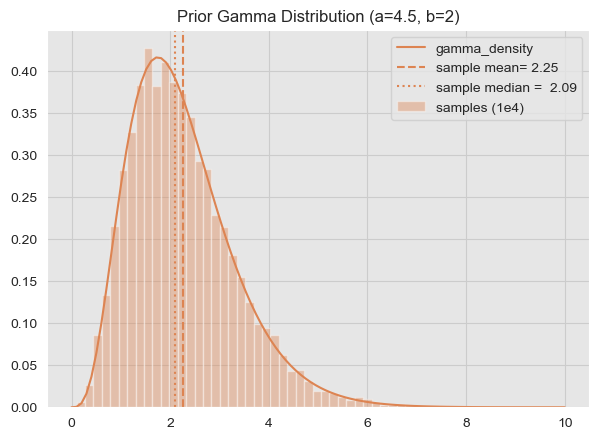

In [5]:
# Generate samples. 
gamma_prior_samples = gamma_prior.sample(sample_shape=1e4)
# Plot.
fig, ax = plt.subplots(figsize=(7, 5))
# Domain to plot. 
x = np.linspace(start=0, stop=10, num=100)
# Plot samples distribution.
sns.distplot(
    a=gamma_prior_samples, 
    color=sns_c[1], 
    kde=False, 
    norm_hist=True, 
    label='samples (1e4)', 
    ax=ax
)
# Plot density function of the gamma density.
sns.lineplot(
    x=x, 
    y=ss.gamma.pdf(x, a=a, scale=1/b), 
    color=sns_c[1], 
    label='gamma_density', 
    ax=ax
)
# Some Stats.
sample_mean = tf.reduce_mean(gamma_prior_samples)
sample_median = tfp.stats.percentile(x=gamma_prior_samples, q=50)

ax.axvline(
    x=sample_mean, 
    color=sns_c[1], 
    linestyle='--', 
    label=f'sample mean={sample_mean: 0.2f}'
)

ax.axvline(
    x=sample_median, 
    color=sns_c[1], 
    linestyle=':', 
    label=f'sample median = {sample_median: 0.2f}'
)

ax.legend()
ax.set(title=f'Prior Gamma Distribution (a={a}, b={b})');


## Prior Predictive Sampling

Before fitting the model to the data, let us sample form Poisson distributions based on these prior samples for the rate parameter lambda. 

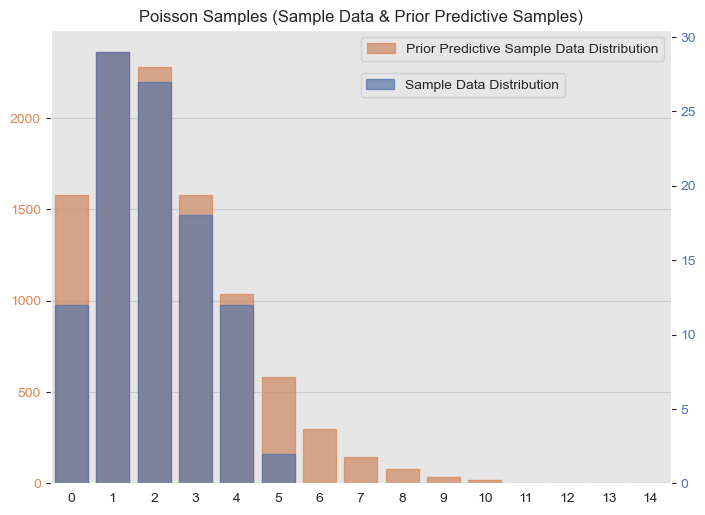

In [6]:
y_prior_pred = tfd.Poisson(rate=gamma_prior_samples).sample(1)
y_prior_pred  = tf.reshape(y_prior_pred, [-1])

y_range_prior, idy_prior, c_prior = tf.unique_with_counts(y_prior_pred)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
sns.barplot(
    x=y_range.numpy(), 
    y=c.numpy(), 
    color=sns_c[0], 
    edgecolor=sns_c[0], 
    alpha=0.7, 
    label='Sample Data Distribution', 
    ax=ax2
)
sns.barplot(
    x=y_range_prior.numpy(), 
    y=c_prior.numpy(), 
    color=sns_c[1], 
    edgecolor=sns_c[1], 
    label='Prior Predictive Sample Data Distribution', 
    alpha=0.7, 
    ax=ax1
)
ax1.set(title=f'Poisson Samples (Sample Data & Prior Predictive Samples)')
ax1.tick_params(axis='y', labelcolor=sns_c[1])
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.legend(loc='upper right')
ax2.grid(None)
ax2.legend(bbox_to_anchor=(0.84, 0.92))
ax2.tick_params(axis='y', labelcolor=sns_c[0])

## Define Model

Next we are going to define our inference model. How do we do this with TFP?

>  TFP performs probabilistic inference by evaluating the model using an unnormalized joint log probability function. The arguments to this joint_log_prob are data and model state. The function returns the log of the joint probability that the parameterized model generated the observed data.^[[An introduction to probabilistic programming, now available in TensorFlow Probability](https://blog.tensorflow.org/2018/12/an-introduction-to-probabilistic.html)] 

In [7]:
# First we set the model specification. 
def build_model(a=4.5, b=2):
    # Prior Distribution.
    rate = tfd.Gamma(concentration=a, rate=b)
    # Likelihood: Independent samples of a Poisson distribution. 
    observations = lambda rate: tfd.Sample(
        distribution=tfd.Poisson(rate=rate), 
        sample_shape=len(poisson_samples)
    )
    return tfd.JointDistributionNamed(dict(rate=rate, obs=observations))
    
# We set the joint-log-probability as the target variable we want to maximize. 
def target_log_prob_fn(rate):
    model = build_model()
    return model.log_prob(rate=rate, obs=poisson_samples)

## Bayesian Inference


### Grid-Like-Approximation of the Mean

Let us start with a simple approach (compare with [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/), Chapter 3), on which we run a grid search to estimate the value of lambda (rate) which maximizes the joint-log-probability.

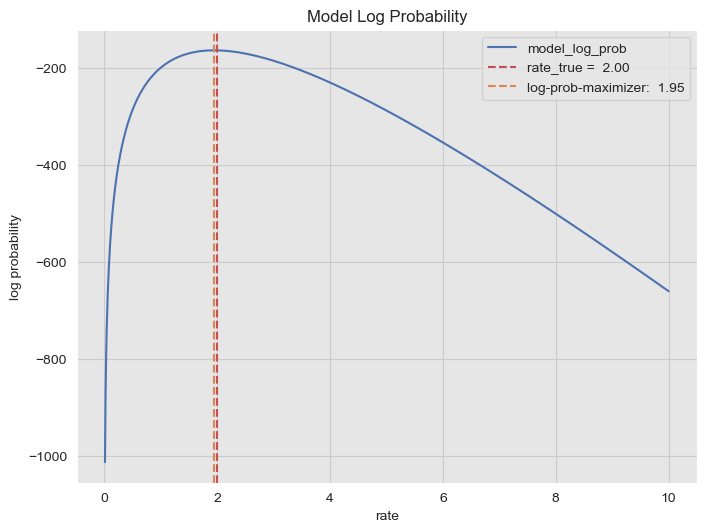

In [8]:
# Define rates range.
rates = np.linspace(start=0.01, stop=10.0, num=1000)

# Compute joint-log-probability.
model_log_probs = np.array([
    target_log_prob_fn(rate).numpy() 
    for rate in rates
])

# Get rate which maximizes the log-probability of the model. 
log_prob_maximizer = rates[np.argmax(model_log_probs)]

# Plot the results. 
fig, ax = plt.subplots() 
sns.lineplot(x=rates, y=model_log_probs, color=sns_c[0], label='model_log_prob', ax=ax)
ax.axvline(x=rate_true, linestyle='--', color=sns_c[3], label=f'rate_true = {rate_true: 0.2f}')
ax.axvline(x=log_prob_maximizer , linestyle='--', color=sns_c[1], label=f'log-prob-maximizer: {log_prob_maximizer: 0.2f}')
ax.legend(loc='upper right')
ax.set(title='Model Log Probability', xlabel='rate', ylabel='log probability');

We see that the values that maximizes the joint-log-distribution is ~ 1.95. Still, we are interested in the distribution of the parameter lambda, not a single point estimate).

### Hamiltonian Monte Carlo Sampling

Next, we are going to use Hamiltonian Monte Carlo Sampling which is a very common way to run Bayesian inference. We are not going to go into the details of the methods, but rather on the direct usage of it using TFP. From TFP's documentation:^[[TFP: Hamiltonian Monte Carlo](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo)]

> Hamiltonian Monte Carlo (HMC) is a Markov chain Monte Carlo (MCMC) algorithm that takes a series of gradient-informed steps to produce a Metropolis proposal. 

Here are some useful references on this topic: 
- [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/), Chapter 9.
- [The Geometry of Hamiltonian Monte Carlo](https://arxiv.org/abs/1112.4118)
- [A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)

For an in-depth description of the objects and methods please refer to the [documentation](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/). 

Let us set up the Hamiltonian Monte Carlo algorithm.

In [9]:
# Size of each chain.
num_results = int(1e4)
# Burn-in steps.
num_burnin_steps = int(1e3)
# Hamiltonian Monte Carlo transition kernel. 
# I TFP a TransitionKernel returns a new state given some old state.
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=target_log_prob_fn,
  step_size=1.0,
  num_leapfrog_steps=3
  
)
# This adapts the inner kernel's step_size.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8)
)
# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in). 
  # Implements MCMC via repeated TransitionKernel steps.
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=1.0,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
    
  return samples

Next, we run it and get samples from the posterior distribution for different chains. 

In [10]:
# Set number of chains. 
num_chains = 5
# Run sampling. 
chains = [run_chain() for i in range(num_chains)]

### Sampling Results

Let us visualize the samples and their distribution. 

In [11]:
# We store the samples in a pandas dataframe.
chains_df = pd.DataFrame([t.numpy() for t in chains])
chains_df = chains_df.T.melt(var_name='chain_id', value_name='sample')

chains_df.head()

,chain_id,sample
0,0,1.867492
1,0,1.883758
2,0,1.917210
3,0,1.920594
4,0,1.920594


We plot the samples for each chain and indicate their mean and plus/minus 2 standard deviations from the mean.

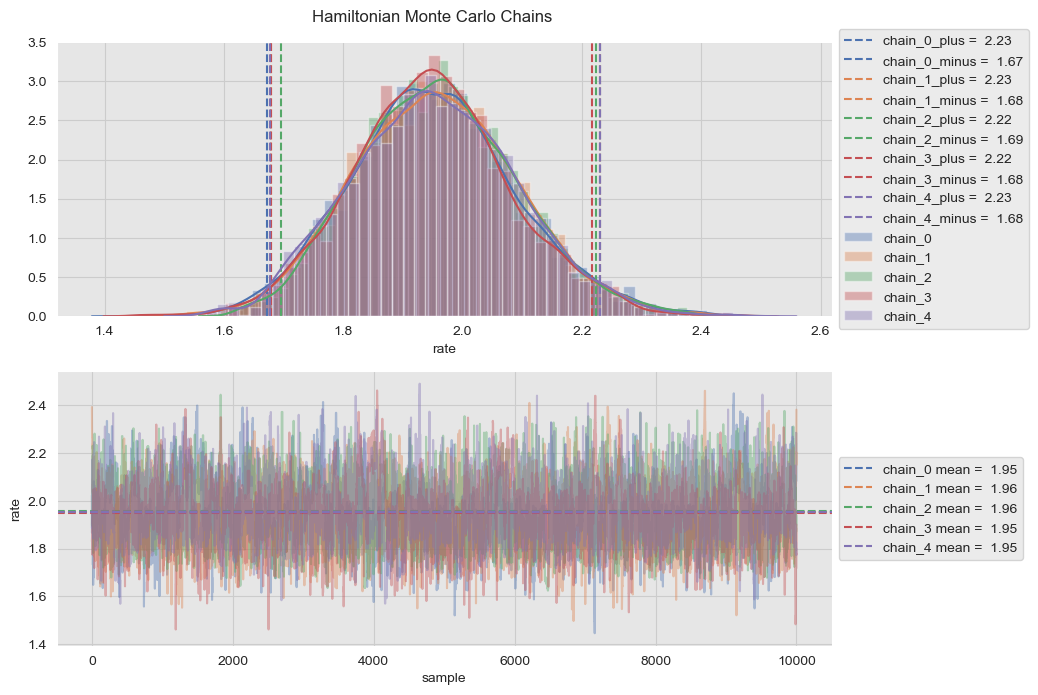

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

for i in range(5):

    chain_samples = chains_df \
        .query(f'chain_id == {i}') \
        .reset_index(drop=True) \
        ['sample']

    chain_samples_mean = chain_samples.mean()
    chain_samples_std = chain_samples.std()
    chain_samples_plus = chain_samples_mean + 2*chain_samples_std
    chain_samples_minus = chain_samples_mean - 2*chain_samples_std

    sns.distplot(a=chain_samples, color=sns_c[i], hist_kws={'alpha': 0.4}, label=f'chain_{i}', ax=ax[0])
    ax[0].axvline(x=chain_samples_plus, linestyle='--', color=sns_c[i], label=f'chain_{i}_plus = {chain_samples_plus: 0.2f}')
    ax[0].axvline(x=chain_samples_minus, linestyle='--', color=sns_c[i], label=f'chain_{i}_minus = {chain_samples_minus: 0.2f}')
    ax[1].plot(chain_samples, c=sns_c[i], alpha=0.4)
    ax[1].axhline(y=chain_samples_mean, linestyle='--', color=sns_c[i], label=f'chain_{i} mean = {chain_samples_mean: 0.2f}')

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set(xlabel='rate', ylabel='')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set(xlabel='sample', ylabel='rate')
plt.suptitle('Hamiltonian Monte Carlo Chains', y=0.92);

The samples look convergent (more model diagnostics are out of the scope for this short-example, but they are key as part of the analysis). 

## Predictions

### Posterior Distribution
Similarly as above, we no plot the distribution for all the chains together. 

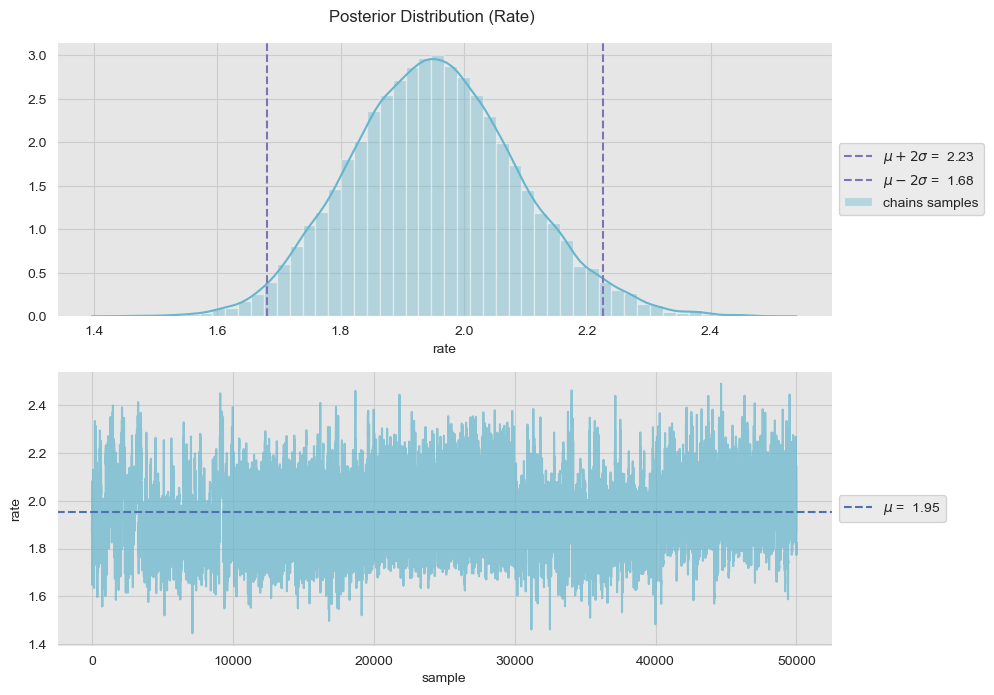

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

chain_samples = chains_df['sample']
chain_samples_mean = chain_samples.mean()
chain_samples_std = chain_samples.std()
chain_samples_plus = chain_samples_mean + 2*chain_samples_std
chain_samples_minus = chain_samples_mean - 2*chain_samples_std

sns.distplot(a=chain_samples, color=sns_c[9], label=f'chains samples', ax=ax[0])
ax[0].axvline(x=chain_samples_plus, linestyle='--', color=sns_c[4], label=f'$\mu + 2\sigma$ = {chain_samples_plus: 0.2f}')
ax[0].axvline(x=chain_samples_minus, linestyle='--', color=sns_c[4], label=f'$\mu - 2\sigma$ = {chain_samples_minus: 0.2f}')
ax[1].plot(chain_samples, c=sns_c[9], alpha=0.7)
ax[1].axhline(y=chain_samples_mean, linestyle='--', color=sns_c[0], label=f'$\mu$ = {chain_samples_mean: 0.2f}')

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set(xlabel='rate', ylabel='')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set(xlabel='sample', ylabel='rate')
plt.suptitle(f'Posterior Distribution (Rate)', y=0.92);

### Posterior Predictive Sampling

Finally, let us sample from the posterior distribution of the rate parameter and then generate Poisson samples from them.

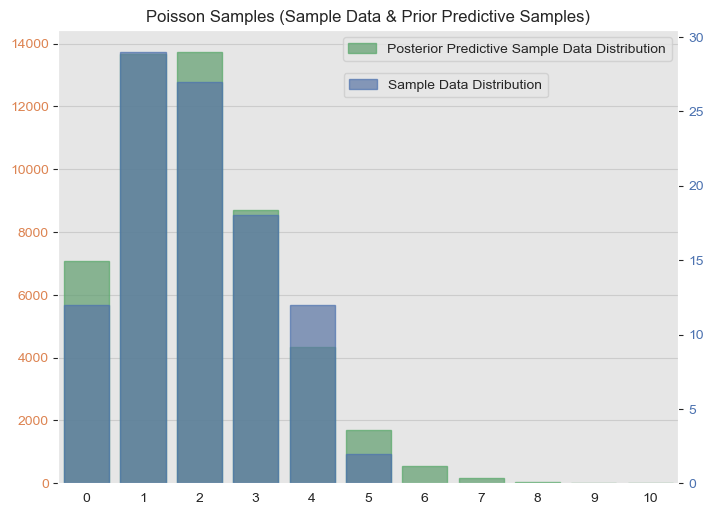

In [14]:
y_post_pred = tfd.Poisson(rate=chains_df['sample']).sample(1)
y_post_pred  = tf.reshape(y_post_pred, [-1])

y_range_prior, idy_prior, c_prior = tf.unique_with_counts(y_post_pred)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
sns.barplot(
    x=y_range.numpy(), 
    y=c.numpy(), 
    color=sns_c[0], 
    edgecolor=sns_c[0], 
    alpha=0.7, 
    label='Sample Data Distribution', 
    ax=ax2
)
sns.barplot(
    x=y_range_prior.numpy(), 
    y=c_prior.numpy(), 
    color=sns_c[2], 
    edgecolor=sns_c[2], 
    label='Posterior Predictive Sample Data Distribution', 
    alpha=0.7, 
    ax=ax1
)
ax1.set(title=f'Poisson Samples (Sample Data & Prior Predictive Samples)')
ax1.tick_params(axis='y', labelcolor=sns_c[1])
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.legend(loc='upper right')
ax2.grid(None)
ax2.legend(bbox_to_anchor=(0.8, 0.92))
ax2.tick_params(axis='y', labelcolor=sns_c[0])

The initial samples and the predicted samples distributions look very similar. 